## Intro
In this notebook, we will build a neural network model that encode a perfume by its top, middle and base notes to predict its gender and fragrance. The model achieved 90% accuracy in gender prediction and 50% accuracy in fragrance prediction, and most importantly, we got a encoder that generates the vectorized representations of the perfumes.

The following notebook is organized into 3 parts:
1. Training / Testing Data Preparation
2. Building and Training the Model 
3. Model Performance Evaluation
4. Explore the Perfume Representations from the Encoder

### Training / Testing Data Preparation

In [1]:
import pandas as pd
import numpy as np

np.random.seed(0)

#### Data Cleaning

In [2]:
df = pd.read_csv('data/perfumes.csv')

# top, middle, and base notes are all required in our inputs. Drop the row if any of them are missing
df = df[~df[['top','middle','base']].isna().any(1)]
df['top'] = df['top'].fillna('[]').apply(eval)
df['middle'] = df['middle'].fillna('[]').apply(eval)
df['base'] = df['base'].fillna('[]').apply(eval)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23907 entries, 0 to 37801
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   iurl       23907 non-null  object 
 1   title      23907 non-null  object 
 2   ifullname  23907 non-null  object 
 3   cnname     23743 non-null  object 
 4   enname     23907 non-null  object 
 5   s0         23907 non-null  int64  
 6   s1         23907 non-null  int64  
 7   isscore    23907 non-null  float64
 8   istotal    23907 non-null  int64  
 9   ptimevote  23907 non-null  int64  
 10  brand      23907 non-null  object 
 11  brandid    23907 non-null  int64  
 12  attrib     23872 non-null  object 
 13  perfumer   9709 non-null   object 
 14  fragrance  22284 non-null  object 
 15  top        23907 non-null  object 
 16  middle     23907 non-null  object 
 17  base       23907 non-null  object 
 18  mainodor   23907 non-null  object 
 19  perfumers  9709 non-null   object 
 20  wikida

The target values we try to predict are gender and frangrance. Before we start construct our training and testing set, we need to clean the data. 

In [3]:
df['attrib'].value_counts()

女香     12006
中性香     6466
男香      5394
女性香        3
中性         2
男性香        1
Name: attrib, dtype: int64

First we clean the gender column. We have duplicated values standing for same output ('女香' and '女性香' both for female), we replace them with a dict. 
There is also values standing for unisex perfumes, which is confusing for the model. Since our ultimate goal is to learn the representations of the perfumes, I decided to simply by drop the unisex label.

In [4]:
gender_adj = {
    '女香':'F',
    '女性香':'F',
    '男香':'M',
    '男性香':'M',
    '中性':'N',
    '中性香':'N'
}

df['attrib'] = df['attrib'].map(gender_adj)
df['attrib'].value_counts()

F    12009
N     6468
M     5395
Name: attrib, dtype: int64

In [5]:
df['fragrance'].value_counts()

花香果香调     3030
花香调       2434
东方花香调     2332
木质花香调     1941
木质馥奇香调    1267
木质东方调     1093
馥奇香调       951
东方调        873
辛辣木质调      851
花果香美食调     789
柑橘馥奇香调     733
花香西普调      713
辛辣东方调      599
东方美食调      563
绿叶花香调      551
辛辣馥奇香调     369
皮革调        332
木质调        316
东方馥奇香调     312
柑橘调        307
水生馥奇香调     258
水生花香调      238
西普调        229
果香馥奇香调     217
醛香花香调      215
果香西普调      206
绿叶馥奇香调     175
木质西普调      167
水生木质调      137
柑橘美食调       69
绿叶调          6
果香调          5
美食调          4
水生调          2
Name: fragrance, dtype: int64

Then we clean the fragrance column. The origin category of nosetime.com divide perfumes into 34 fragrances. This results into very small sample number for some fragrances. After researching, I further categorized 11 fragrance families according to nosetime.com. 

In [6]:
fragrance_adj = {
    '辛辣木质调': '木质调',
     '花香果香调': '果香调',
     '木质东方调': '东方调',
     '水生花香调': '花香调',
     '果香调': '果香调',
     '花香调': '花香调',
     '木质馥奇香调': '馥奇香调',
     '木质花香调': '花香调',
     '木质西普调': '西普调',
     '花香西普调': '西普调',
     '柑橘馥奇香调': '馥奇香调',
     '绿叶花香调': '花香调',
     '醛香花香调': '花香调',
     '东方馥奇香调': '馥奇香调',
     '东方调': '东方调',
     '皮革调': '皮革调',
     '果香馥奇香调': '馥奇香调',
     '东方花香调': '花香调',
     '辛辣东方调': '东方调',
     '绿叶馥奇香调': '馥奇香调',
     '木质调': '木质调',
     '果香西普调': '西普调',
     '柑橘调': '柑橘调',
     '辛辣馥奇香调': '馥奇香调',
     '东方美食调': '美食调',
     '花果香美食调': '美食调',
     '西普调': '西普调',
     '馥奇香调': '馥奇香调',
     '水生木质调': '木质调',
     '水生馥奇香调': '馥奇香调',
     '柑橘美食调': '美食调',
     '绿叶调': '绿叶调',
     '美食调': '美食调',
     '水生调': '水生调'
}
df['fragrance'] = df['fragrance'].map(fragrance_adj)
df['fragrance'].value_counts()

花香调     7711
馥奇香调    4282
果香调     3035
东方调     2565
美食调     1425
西普调     1315
木质调     1304
皮革调      332
柑橘调      307
绿叶调        6
水生调        2
Name: fragrance, dtype: int64

4 categories, '皮革调', '柑橘调', '绿叶调' and '水生调', have less than 1000 samples. We replace them with nan and exclude them from our task.

In [7]:
df.loc[df['fragrance'].isin(['皮革调', '柑橘调', '绿叶调', '水生调']), 'fragrance'] = np.nan
df['fragrance'].value_counts()

花香调     7711
馥奇香调    4282
果香调     3035
东方调     2565
美食调     1425
西普调     1315
木质调     1304
Name: fragrance, dtype: int64

#### Constructing Vocabularies
Before we can feed the data into neural networks, we need to code the fragrance notes and outputs into integers and we need to store the mapping for reverse lookup.

In [8]:
def contruct_note_voc(df):
    voc = {}
    for perf in df.iterrows():
        for note in ['top','middle','base']:
            for ing in perf[1][note]:
                voc[ing] = voc.get(ing, 0) + 1

    voc = pd.Series(voc)
    
    # keep only the notes that appeared more than 50 times
    voc = voc[voc>=50]
    voc = voc.reset_index()['index']
    voc.index += 1 # we need to avoid 0 as index since we will do zero padding later 

    voc_dict = voc.to_dict()
    # add UNK for notes not in the vocabulary
    voc_dict[len(voc)+1] = 'UNK'
    voc_dict_rev = {value:key for key, value in voc_dict.items()}
    
    return voc_dict, voc_dict_rev

voc_dict, voc_dict_rev = contruct_note_voc(df)

In [10]:
# hand-construct output dict
output_dict = {0:'木质调', 1:'果香调', 2:'东方调', 3:'花香调', 4:'馥奇香调', 5:'西普调', 6:'美食调'}
output_dict_rev = {value:key for key, value in output_dict.items()}

#### Construct Training / Test Data Set
Apply the code mapping to convert all inputs and outputs into integers and pad the inputs, then hold out 10% of the data as testing data.

In [174]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_datasets(df, ratio):
    df['y'] = df['fragrance'].map(output_dict_rev)
    df = df[~df['y'].isna()]

    df['x_t'] = df['top'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
    df['x_m'] = df['middle'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
    df['x_b'] = df['base'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
    
    dataset = df[['x_t','x_m','x_b','y']]
    train = dataset.sample(frac=ratio)
    test = dataset.drop(train.index)
    
    train_x, train_y = [train['x_t'].values, train['x_m'].values, train['x_b'].values], train['y'].values
    test_x, test_y = [test['x_t'].values, test['x_m'].values, test['x_b'].values], test['y'].values

    train_x = [pad_sequences(i, maxlen=10) for i in train_x]
    test_x = [pad_sequences(i, maxlen=10) for i in test_x]
    
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = get_datasets(df, 0.9)

<ipython-input-174-0e89a03fa002>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_t'] = df['top'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
<ipython-input-174-0e89a03fa002>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_m'] = df['middle'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
<ipython-input-174-0e89a03fa002>:9: SettingWithCopyWarning: 
A value is tryin

In [175]:
def check_sample_data(sample_index):
    input_x = [notes[sample_index] for notes in train_x]
    output_x = train_y[sample_index]
    print('Input for the sample {} is:'.format(sample_index))
    for i in input_x:
        print(i)
    print('The 3 arrays represent respectively the top, middle, and top notes of this perfume.')
    print('The top notes of the perfume are {}'.format([voc_dict[i] for i in input_x[0] if i != 0]))
    print('The middle notes of the perfume are {}'.format([voc_dict[i] for i in input_x[1] if i != 0]))
    print('The base notes of the perfume are {}'.format([voc_dict[i] for i in input_x[2] if i != 0]), '\n')
    print('Output for the sample {} is:'.format(sample_index))
    print(output_x)
    print('which represents the fragrance: {}'.format(output_dict.get(output_x, 'null')), '\n')
    
for sample_index in range(3):
    check_sample_data(sample_index)

Input for the sample 0 is:
[ 0  0  0  0  0  0  0 24  2 60]
[ 0  0  0  0  0 58 51 56 32 54]
[ 0  0  0  0  0 52  5 53 15 71]
The 3 arrays represent respectively the top, middle, and top notes of this perfume.
The top notes of the perfume are ['橘子', '葡萄柚', '百香果']
The middle notes of the perfume are ['玫瑰', '茉莉', '铃兰', '小苍兰', '桃子']
The base notes of the perfume are ['檀香木', '雪松', '香草', '麝香', '零陵香豆'] 

Output for the sample 0 is:
1.0
which represents the fragrance: 果香调 

Input for the sample 1 is:
[  0   0   0   0   0   0   0 129  72  24]
[  0   0   0   0   0   0  75 125  46  44]
[  0   0   0   0   0   0 130  15   6  23]
The 3 arrays represent respectively the top, middle, and top notes of this perfume.
The top notes of the perfume are ['苹果', '薰衣草', '橘子']
The middle notes of the perfume are ['快乐鼠尾草', '杜松子', '小豆蔻', '老鹳草']
The base notes of the perfume are ['沉香(乌木)', '麝香', '香根草', '橡木苔'] 

Output for the sample 1 is:
0.0
which represents the fragrance: 木质调 

Input for the sample 2 is:
[ 0  0  0 

### Build and Train the Model

#### Define the Helping Class and Functions
PlotProgress class: a callback class to plot the learning curves.
masked_binary_crossentropy & masked_sparse_categorical_crossentropy: loss functions that ignore missing labels.

In [176]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

import datetime
from IPython.display import clear_output
from matplotlib import pyplot as plt

class PlotProgress(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.plot_x = []
        self.plot_loss = []
        self.plot_val_loss = []
        self.plot_acc = []
        self.plot_val_acc = []

    def on_epoch_end(self, epoch, logs):
        clear_output(wait=True)
        self.plot_x.append(epoch)
        self.plot_loss.append(logs['loss'])
        self.plot_val_loss.append(logs['val_loss'])
        self.plot_acc.append(logs['accuracy'])
        self.plot_val_acc.append(logs['val_accuracy'])
        
        plt.figure(figsize=(10,5))
        
        plt.subplot(121)
        plt.plot(self.plot_x, self.plot_loss, label='loss')
        plt.plot(self.plot_x, self.plot_val_loss, label='val_loss')
        plt.title('Loss')
        plt.legend()
        
        plt.subplot(122)
        plt.plot(self.plot_x, self.plot_acc, label='accuracy')
        plt.plot(self.plot_x, self.plot_val_acc, label='val_accuracy')
        plt.title('Accuracy')
        plt.legend()
        
        plt.show()
        
class CustomSave(keras.callbacks.Callback):
    def __init__(self, start_epoch):
        self.start_epoch = start_epoch
        
    def on_train_begin(self, logs):
        self.min_val_loss = 999

    def on_epoch_end(self, epoch, logs):
        val_loss = logs['val_loss']
        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            if epoch >= self.start_epoch:
                print('Saving best model...')
                self.model.save('best_model.h5')

#### Building the Model
In order to make use of two target values to learn a good representation, I constructed a multi-task model using embedding and RNN.
First I encode the perfume by its notes:
1. The top, mid, and base notes are inputed and shuffled within themselves because the order of the notes should not matter;
2. The inputs go through an emdedding lay and get vetorized. Each note is represented by a 128-dimension vector;
3. Since the number of notes for each perfume is not fixed, we feed the notes into RNN to compress them into fixed dimension space;
4. Concate the states of the three RNN, this is the encoded state of the perfume.

Then, I feed the encoded state into to different dense neural network, predicting gender and fragrance respectively.
To avoid overfitting, some dropout layers are inserted between the dense layers.

In [177]:
input_top = keras.Input(shape=(None,), dtype="int32")
input_mid = keras.Input(shape=(None,), dtype="int32")
input_base = keras.Input(shape=(None,), dtype="int32")

shuffle =  layers.Lambda(lambda x: tf.map_fn(tf.random.shuffle, x))

input_top_shuffled = shuffle(input_top)
input_mid_shuffled = shuffle(input_mid)
input_base_shuffled = shuffle(input_base)

embedding = layers.Embedding(len(voc_dict)+1, 128, mask_zero=True)

top_vec = embedding(input_top_shuffled)
mid_vec = embedding(input_mid_shuffled)
base_vec = embedding(input_base_shuffled)

top_encoded = layers.LSTM(80)(top_vec)
mid_encoded = layers.LSTM(80)(mid_vec)
base_encoded = layers.LSTM(80)(base_vec)
encoded = layers.Concatenate()([top_encoded,mid_encoded,base_encoded])

# fragrance = layers.Dense(128, activation="relu")(encoded)
# fragrance = layers.Dropout(0.5)(fragrance)
# fragrance = layers.Dense(64, activation="relu")(encoded)
# fragrance = layers.Dropout(0.5)(fragrance)
# fragrance = layers.Dense(32, activation="relu")(encoded)
# fragrance = layers.Dropout(0.5)(fragrance)
fragrance = layers.Dense(7, activation="sigmoid")(encoded)
fragrance = layers.Softmax()(fragrance)

model = keras.Model([input_top, input_mid, input_base], fragrance)
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_53 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, None)         0           input_52[0][0]                   
                                                                 input_53[0][0]            

#### Compile and Train
Since this is a multi-task model, we need to assign weights to the loss of each task. Our target is to learn a good representation of a perfume and fragrance is a more important feature than its gender. So I put more weight on task 2 than task 1.

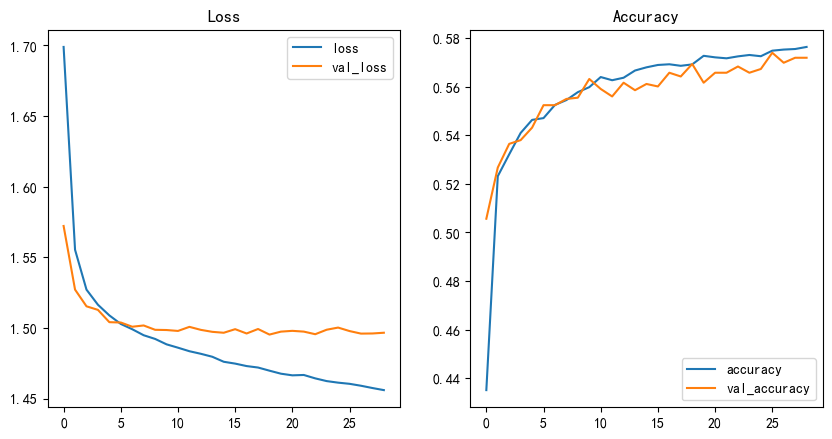

In [178]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
plot_callback = PlotProgress()
save_callback = CustomSave(5)

model.fit(train_x, train_y, batch_size=100, epochs=500, validation_split=0.1, 
          callbacks=[early_stopping_callback, plot_callback, save_callback])

### Model Performance Evaluation

In [179]:
# compute loss and accuracy on test data
model.evaluate(test_x, test_y)

68/68 [==============================] - 0s 4ms/step - loss: 1.5118 - accuracy: 0.5605


[1.5118446350097656, 0.5605360269546509]

In [130]:
model = keras.models.load_model('best_model.h5')

In [180]:
from sklearn.metrics import confusion_matrix

pred = model.predict_on_batch(test_x).argmax(1)
cm = confusion_matrix(pred, test_y)

print('Accuracy: {:.1%}'.format((cm*np.eye(7)).sum() / cm.sum()))
print(pd.DataFrame(cm, index=output_dict.values(), columns=output_dict.values()), '\n')

Accuracy: 56.7%
      木质调  果香调  东方调  花香调  馥奇香调  西普调  美食调
木质调     9    0    7    0     7    0    0
果香调     0   68    2    9     8    4    6
东方调    27    1  107   32    26    9   11
花香调    14  221   76  650    70  106   58
馥奇香调   76   11   57   34   338   26    8
西普调     0    0    0    0     0    0    0
美食调     2    7    5   14     1    2   55 



### Explore the Perfume Representations from the Encoder
The deeper layers including input, embedding, and RNN layers are used to encode the perfume by its fragrance notes. After training on the task, they should be optimized to learn a good representation of the perfume's fragrance.

Let's explore the representations by:
1. Encode perfumes into representations and visualize their relationships by T-SNE;
2. Use the representation in logistic regression for gender prediction, compared to regression directly on one-hot encoding of the notes;
3. Calculate cosine distances between perfumes and find similar perfumes.

In [181]:
encoder = keras.Model([input_top, input_mid, input_base], encoded)

def encoding(df, encoder):   
    df['x_t'] = df['top'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
    df['x_m'] = df['middle'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
    df['x_b'] = df['base'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
    
    notes =  [df['x_t'].values, df['x_m'].values, df['x_b'].values]
    notes = [pad_sequences(i, maxlen=10) for i in notes]

    encoded = encoder(notes)
    
    return encoded

#### 1. Encode & Visualize

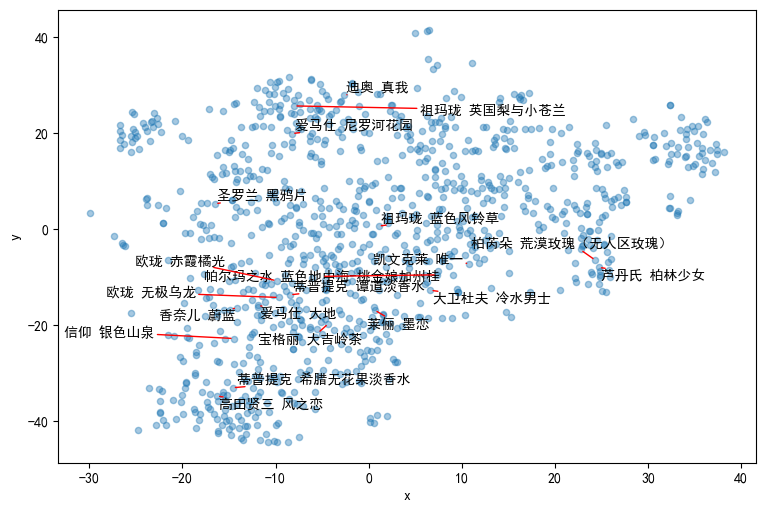

In [88]:
from sklearn.manifold import TSNE
import matplotlib
from adjustText import adjust_text

plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False
plt.rcParams["figure.dpi"] = 100

perfumes = df.nlargest(1000, 'istotal') # encode top 1000 perfumes
representation = pd.DataFrame(encoding(perfumes, encoder), index=perfumes['title'])
representation2D = TSNE(early_exaggeration=40).fit_transform(representation)
representation2D = pd.DataFrame(representation2D, index=perfumes['title'], columns=['x','y'])

ax = representation2D.plot('x','y', kind='scatter', figsize=(9,6), alpha=0.4)
texts = [ax.text(row[1]['x'], row[1]['y'], row[1]['title']) for row in representation2D.reset_index()[:20].iterrows()]
adjust_text(texts, arrowprops={'arrowstyle':'-','color':'r'})
plt.show()

#### 2. Predict Gender by Encoded Representation vs. One-Hot Encoding (Benchmark)
Both model will take the form of a simple Logistic Regression. Model 1 will use the representations generated by our encoder and Model 2 will use the one-hot encoding of a perfume's fragrance notes.

In [182]:
from sklearn.model_selection import train_test_split

data = df[~df['attrib'].isna()]
X = data[['top','middle','base']]
y = data['attrib'].values

# input for model 1 should be encoded representations
X_1 = encoding(X, encoder).numpy()

# input for model 2 should be one-hot
X['x'] = X['top'] + X['middle'] + X['base']
X_2 = X[['x']].explode('x').reset_index().drop_duplicates()
X_2['value'] = 1
X_2 = pd.pivot(X_2, 'index', 'x', 'value').fillna(0)

train_x_1, test_x_1, train_x_2, test_x_2, train_y, test_y = train_test_split(X_1, X_2, y, test_size=0.1)

print('Model 1 input shape:', train_x_1.shape)
print('Model 2 input shape:', train_x_2.shape)

<ipython-input-181-b1000cb9e932>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_t'] = df['top'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
<ipython-input-181-b1000cb9e932>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_m'] = df['middle'].apply(lambda x: [voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in x] if len(x) > 0 else [voc_dict_rev['UNK']])
<ipython-input-181-b1000cb9e932>:6: SettingWithCopyWarning: 
A value is tryin

Model 1 input shape: (21484, 240)
Model 2 input shape: (21484, 1221)


In [183]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

model_1 = LogisticRegression(max_iter=5000).fit(train_x_1, train_y)
model_2 = LogisticRegression(max_iter=5000).fit(train_x_2, train_y)

In [184]:
from sklearn.metrics import classification_report

pred_1 = model_1.predict(test_x_1)
pred_2 = model_2.predict(test_x_2)

In [185]:
print(classification_report(train_y, model_1.predict(train_x_1)))

              precision    recall  f1-score   support

           F       0.78      0.89      0.83     10807
           M       0.69      0.74      0.71      4871
           N       0.57      0.39      0.46      5806

    accuracy                           0.72     21484
   macro avg       0.68      0.67      0.67     21484
weighted avg       0.70      0.72      0.71     21484



In [186]:
print(classification_report(train_y, model_2.predict(train_x_2)))

              precision    recall  f1-score   support

           F       0.80      0.90      0.85     10807
           M       0.75      0.77      0.76      4871
           N       0.66      0.49      0.56      5806

    accuracy                           0.76     21484
   macro avg       0.74      0.72      0.72     21484
weighted avg       0.75      0.76      0.75     21484



In [187]:
print(classification_report(test_y, pred_1))

              precision    recall  f1-score   support

           F       0.77      0.87      0.82      1202
           M       0.67      0.73      0.70       524
           N       0.57      0.39      0.46       662

    accuracy                           0.71      2388
   macro avg       0.67      0.67      0.66      2388
weighted avg       0.69      0.71      0.69      2388



In [188]:
print(classification_report(test_y, pred_2))

              precision    recall  f1-score   support

           F       0.78      0.88      0.83      1202
           M       0.72      0.77      0.74       524
           N       0.62      0.44      0.52       662

    accuracy                           0.73      2388
   macro avg       0.71      0.70      0.69      2388
weighted avg       0.72      0.73      0.72      2388



#### 3. Calculate Cosine Distance & Find Similar Perfumes

In [71]:
from sklearn.metrics.pairwise import cosine_similarity

names = list(representation.index)
all_consine_dist = pd.DataFrame(cosine_similarity(representation), index=names, columns=names)
pair_cosine_dist = pd.DataFrame(np.triu(cosine_similarity(representation),1), index=names, columns=names)
pair_cosine_dist.index.name = 'perfume_1'
pair_cosine_dist.columns.name = 'perfume_2'
pair_cosine_dist = pair_cosine_dist.stack().rename('cosine').reset_index()

In [74]:
pair_cosine_dist.nlargest(20, 'cosine')

,perfume_1,perfume_2,cosine
469936,阿玛尼 高定私藏清新系列 - 苏州牡丹,阿玛尼 私藏系列-苏州牡丹 珍珠丝绸限量版,0.996522
452996,香奈儿 5号低调奢华版,香奈儿 5号低调奢华2015版,0.992319
308650,古驰 花之舞淡香水,古驰 花之舞淡香精,0.991764
248268,香奈儿 5号淡香水,香奈儿 5号香精版,0.986593
141919,香奈儿 5号之水,香奈儿 香奈儿五号之水圣诞限量版,0.986231
55248,香奈儿 5号,香奈儿 5号淡香水,0.983607
55268,香奈儿 5号,香奈儿 5号香精版,0.981015
201627,娇兰 遗产,娇兰 遗产淡香精,0.976858
292756,丽娜蕙姿 比翼双飞,罗拔贝格 匪盗,0.976505
268756,香奈儿 5号香精版,罗拔贝格 匪盗,0.975124


In [75]:
pair_cosine_dist.nsmallest(20, 'cosine')

,perfume_1,perfume_2,cosine
37121,蒂普提克 杜桑（晚香玉）淡香水,蒂普提克 东京柑橘,-0.661325
121188,蒂普提克 东京柑橘,柏芮朵 花序,-0.655822
461896,纳茜素 精纯麝香女士,花宫娜 自然：雪松,-0.647859
205374,祖玛珑 忍冬印蒿,罗意威 001男士淡香水（事后清晨男士）,-0.647321
136769,约翰·瓦维托斯 艺术工匠（黄藤编）,娇兰 艺术沙龙 - 亚美尼亚木香,-0.646345
121874,蒂普提克 东京柑橘,麦当娜 真心话大冒险,-0.642609
121958,蒂普提克 东京柑橘,娇兰 艺术沙龙 - 栀子花（血腥栀子）,-0.642403
108121,柏芮朵 白色浪漫,蒂普提克 东京柑橘,-0.641311
35152,纳茜素 她的同名女士淡香水,宝格丽 水漾夜茉莉,-0.640521
121456,蒂普提克 东京柑橘,潘海利根 瓦娅,-0.639833


In [76]:
all_consine_dist.loc['大卫杜夫 冷水男士'].sort_values()

迪奥 红毒淡香精         -0.267969
祖玛珑 英国橡树与红醋栗     -0.257403
蒙塔莱 浓咖啡          -0.252288
馥马尔 窈窕如她（贵妇肖像）   -0.247349
艾莉萨博 水裳          -0.237525
                    ...   
阿莎罗 铬元素           0.907017
伊丽莎白雅顿 白茶         0.911686
娇兰 遗产淡香精          0.924868
娇兰 遗产             0.946400
大卫杜夫 冷水男士         1.000000
Name: 大卫杜夫 冷水男士, Length: 1000, dtype: float64

In [77]:
all_consine_dist.loc['爱马仕 大地'].sort_values()

迪奥 真我纯香                    -0.455315
卡地亚 偷吻                     -0.446203
芦丹氏 穆斯林茉莉                  -0.438123
纳茜素 精纯麝香女士                 -0.426718
达西塔香氛 Melodie De L'Amour   -0.411561
                              ...   
娇兰 德比                       0.856049
香水故事 1740 萨德侯爵              0.857705
圣罗兰 M7乌木精纯                  0.858727
馥马尔 摩登男士                    0.873830
爱马仕 大地                      1.000000
Name: 爱马仕 大地, Length: 1000, dtype: float64

In [1183]:
np.flip(cosine_similarity(encoded.loc['大卫杜夫 冷水男士'].values.reshape(1,-1), encoded.values).argsort())[:,:20]

array([[1585, 1334, 5768, 1339, 5421, 5602, 2426, 5324,  165, 4772, 1307,
          83,  733, 5102, 2002, 3897, 3151,  581, 3107, 2017]],
      dtype=int64)

In [1194]:
encoded.iloc[5324].name

'拉尔夫·劳伦 马球（绿马球）'

In [1189]:
cosine_similarity(encoded.loc['大卫杜夫 冷水男士'].values.reshape(1,-1), encoded.loc['维果&罗夫 解药'].values.reshape(1,-1))

array([[0.76980627]], dtype=float32)

In [197]:
voc_dict

{1: '橙子',
 2: '葡萄柚',
 3: '胡椒',
 4: '天竺葵',
 5: '广藿香',
 6: '雪松',
 7: '香根草',
 8: '安息香脂',
 9: '胡萝卜',
 10: '番茄',
 11: '芒果',
 12: '牡丹',
 13: '风信子',
 14: '莲花',
 15: '劳丹脂',
 16: '鸢尾花',
 17: '肉桂',
 18: '麝香',
 19: '焚香',
 20: '柠檬',
 21: '榄香脂',
 22: '琥珀',
 23: '粉红胡椒',
 24: '紫罗兰',
 25: '冷杉',
 26: '橡木苔',
 27: '橘子',
 28: '香柠檬',
 29: '橙花',
 30: '夹竹桃',
 31: '柏树',
 32: '无花果叶',
 33: '杜松',
 34: '开心果',
 35: '茶叶',
 36: '桂花',
 37: '小苍兰',
 38: '皮革',
 39: '杏',
 40: '大黄',
 41: '红浆果',
 42: '水',
 43: '栀子花',
 44: '香豌豆',
 45: '绿叶',
 46: '白色花系',
 47: '木质香',
 48: '柑橘',
 49: '老鹳草',
 50: '辛香料',
 51: '小豆蔻',
 52: '花香',
 53: '生姜',
 54: '苦橙',
 55: '晚香玉',
 56: '茉莉',
 57: '檀香木',
 58: '香草',
 59: '桃子',
 60: '依兰',
 61: '接骨木花',
 62: '铃兰',
 63: '水仙花',
 64: '玫瑰',
 65: '含羞草',
 66: '百香果',
 67: '花椒',
 68: '琥珀木',
 69: '乳香',
 70: '希蒂莺',
 71: '芫荽',
 72: '康乃馨',
 73: '橙花油',
 74: '蜂蜜',
 75: '杏树',
 76: '杏树花',
 77: '醛',
 78: '零陵香豆',
 79: '薰衣草',
 80: '干草',
 81: '甘草',
 82: '快乐鼠尾草',
 83: '肉豆蔻',
 84: '巴西红木',
 85: '松树',
 86: '鼠尾草',
 87: '鸢尾根',
 8

In [271]:
def pred_attrib(top, middle, base):
    top_enc = np.asarray([[voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in top]])
    middle_enc = np.asarray([[voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in middle]])
    base_enc = np.asarray([[voc_dict_rev.get(i, voc_dict_rev['UNK']) for i in base]])
    feature = [keras.preprocessing.sequence.pad_sequences(i, maxlen=10) for i in [top_enc,middle_enc,base_enc]]
    pred = model.predict(feature)
    
    return pred

In [285]:
top = ['香柠檬', '香橼']
middle = ['生姜', '雪松', '花香']
base = ['香根草', '安息香脂', '麝香']

pred_attrib(top, middle, base)

array([[0.57082057, 0.21913573, 0.21004365]], dtype=float32)

In [282]:
df[df['title'].str.contains('香柠檬')]

,iurl,title,ifullname,cnname,enname,s0,s1,isscore,istotal,ptimevote,brand,brandid,attrib,perfumer,fragrance,top,middle,base,mainodor,perfumers,wikidata,poster,intro,tb,odor,x_t,x_m,x_b,y
155,guerlain-aqua-allegoria-bergamote-calabria,娇兰 花草水语-卡拉布利亚香柠檬,娇兰 花草水语-卡拉布利亚香柠檬 Guerlain Aqua Allegoria Berga...,娇兰 花草水语-卡拉布利亚香柠檬,"Guerlain Aqua Allegoria Bergamote Calabria, 2017",0,8,7.9,455,58.0,娇兰,10028067,中性香,"Delphine Jelk,Thierry Wasser",柑橘调,"[香柠檬, 苦橙叶]","[小豆蔻, 生姜]","[木质香, 麝香]","[{'cnt': '104', 'uoodor': '香柠檬', 'wid': '19238...","['Delphine Jelk', 'Thierry Wasser']","[{'wid': '10028067', 'wname': '娇兰', 'woriname'...",NaN,NaN,{'try': 'https://weidian.com/item.html?itemID=...,NaN,"[28, 104]","[51, 53]","[47, 18]",1
647,jo-malone-wild-flowers-weeds-hemlock-bergamot,祖玛珑 运河花草系列 - 铁杉与香柠檬,祖玛珑 运河花草系列 - 铁杉与香柠檬 Jo Malone Wild Flowers & W...,祖玛珑 运河花草系列 - 铁杉与香柠檬,Jo Malone Wild Flowers & Weeds - Hemlock & Ber...,0,8,7.6,89,52.0,祖玛珑,10097559,中性香,Yann Vasnier，Louise Turner,绿叶花香调,[香柠檬],[铁杉花],[天芥菜],"[{'cnt': '11', 'uoodor': '含羞草', 'wid': '78206'...",['Yann Vasnier，Louise Turner'],"[{'wid': '10097559', 'wname': '祖玛珑', 'woriname...",NaN,NaN,NaN,"['铁杉花', '脂粉味', '花香', '香柠檬', '含羞草', '天芥菜', '黄瓜']",[28],[403],[133],1
1210,tom-ford-venetian-bergamot,汤姆·福特 威尼斯香柠檬,"汤姆·福特 威尼斯香柠檬 Tom Ford Venetian Bergamot, 2015",汤姆·福特 威尼斯香柠檬,"Tom Ford Venetian Bergamot, 2015",1,9,8.5,211,70.0,汤姆·福特,10053206,中性香,NaN,辛辣木质调,"[香柠檬, 胡椒, 粉红胡椒, 生姜]","[依兰, 栀子花, 雪松, 刺椒, 木兰]","[檀香木, 零陵香豆, 琥珀, 克什米尔木]","[{'cnt': '46', 'uoodor': '香柠檬', 'wid': '19238'...",NaN,"[{'wid': '10028732', 'wname': '琥珀', 'woriname'...",34507.0,汤姆•福特于1986年毕业于帕尔森设计学校。起初以建筑学为专业，曾经先后供职于“凯西•哈德维...,NaN,NaN,"[28, 3, 23, 53]","[60, 43, 6, 403, 166]","[57, 78, 22, 240]",1
4921,acqua-parma-mediterraneo-bergamotto,帕尔玛之水 蓝色地中海-香柠檬,帕尔玛之水 蓝色地中海-香柠檬 Acqua di Parma Blu Mediterrane...,帕尔玛之水 蓝色地中海-香柠檬,Acqua di Parma Blu Mediterraneo Bergamotto di ...,0,8,8.4,1570,50.0,帕尔玛之水,10051198,中性香,NaN,木质馥奇香调,"[香柠檬, 香橼]","[生姜, 雪松, 花香]","[香根草, 安息香脂, 麝香]","[{'cnt': '427', 'uoodor': '香柠檬', 'wid': '19238...",NaN,"[{'wid': '10051198', 'wname': '帕尔玛之水', 'worina...",25668.0,Bergamotto di Calabria卡拉布里亚，一片热情、坚定的土地，似乎镶嵌在广阔...,{'try': 'https://weidian.com/item.html?itemID=...,NaN,"[28, 107]","[53, 6, 52]","[7, 8, 18]",1
5489,lelabo-labo-bergamote-perfume,香水实验室 香柠檬22香精油,香水实验室 香柠檬22香精油 Le Labo Bergamote 22 Perfume Oi...,香水实验室 香柠檬22香精油,"Le Labo Bergamote 22 Perfume Oil, 2012",0,0,0.0,4,80.0,香水实验室,10090657,中性香,Daphne Bugey,柑橘馥奇香调,"[香柠檬, 苦橙叶, 葡萄柚]","[肉豆蔻, 橙花]","[雪松, 琥珀, 麝香, 香根草]","[{'cnt': '3', 'uoodor': '苦橙', 'wid': '80633'},...",['Daphne Bugey'],"[{'wid': '10028732', 'wname': '琥珀', 'woriname'...",NaN,2006年，Fabrice Penot 和 Eddie Roschi在美国纽约一同创立的Le...,NaN,NaN,"[28, 104, 2]","[83, 29]","[6, 22, 18, 7]",1
5683,foshougan-different-company-bergamote,别样公司 香柠檬,"别样公司 香柠檬 The Different Company Bergamote, 2003",别样公司 香柠檬,"The Different Company Bergamote, 2003",0,8,7.7,62,50.0,别样公司,10022272,中性香,Jean-Claude Ellena,柑橘馥奇香调,"[香柠檬, 生姜]","[橙花, 绿叶]","[大黄, 麝香]","[{'cnt': '26', 'uoodor': '香柠檬', 'wid': '19238'...",['Jean-Claude Ellena'],"[{'wid': '10022272', 'wname': '别样公司', 'worinam...",NaN,在平凡之中追寻不凡。佛手柑的气息愉人而持久、在许多清新调性的香水之中都被广為使用，但却也因此...,NaN,NaN,"[28, 53]","[29, 45]","[40, 18]",1
8694,aftelier-bergamoss,阿福特莱尔 香柠檬与苔藓,"阿福特莱尔 香柠檬与苔藓 Aftelier Bergamoss, 2015",阿福特莱尔 香柠檬与苔藓,"Aftelier Bergamoss, 2015",0,0,0.0,1,20.0,阿福特莱尔,10066677,中性香,Mandy Aftel,花香西普调,"[香柠檬, 橙子]","[桃子, 花香, 肉豆蔻]","[橡木苔, 绿叶, 香豆素, 麝猫香]","[{'cnt': '2', 'uoodor': '橡木苔', 'wid': '25135'}...",['Mandy Aftel'],"[{'wid': '10066677', 'wname': '阿福特莱尔', 'worina...",33739.0,Aftelier Perfumes是一家来自于美国加利福尼亚的生产纯天然型香水的公司。公司的...,NaN,NaN,"[28, 1]","[59, 52, 83]","[26, 45, 119, 128]",1
9008,angel-schlesser-eau-de-cologne-bergamota,安吉斯勒塞 香柠檬古龙水,安吉斯勒塞 香柠檬古龙水 Angel Schlesser Eau de Cologne Be...,安吉斯勒塞 香柠檬古龙水,"Angel Schlesser Eau de Cologne Bergamota, 2016",0,0,0.0,2,60.0,安吉斯勒塞,10052252,女香,Alberto Morillas,木质花香调,"[黑加仑, 橘子, 香柠檬]","[茉莉, 白色花系, 栀子花, 橙花]","[麝香, 安息香脂, 檀香木]","[{'cnt': '3', 'uoodor': '香柠檬', 'wid': '19238'}...",['Alberto Morillas'],"[{'wid

In [284]:
df.loc[4921]

iurl                       acqua-parma-mediterraneo-bergamotto
title                                          帕尔玛之水 蓝色地中海-香柠檬
ifullname    帕尔玛之水 蓝色地中海-香柠檬 Acqua di Parma Blu Mediterrane...
cnname                                         帕尔玛之水 蓝色地中海-香柠檬
enname       Acqua di Parma Blu Mediterraneo Bergamotto di ...
s0                                                           0
s1                                                           8
isscore                                                    8.4
istotal                                                   1570
ptimevote                                                   50
brand                                                    帕尔玛之水
brandid                                               10051198
attrib                                                     中性香
perfumer                                                   NaN
fragrance                                               木质馥奇香调
top                                                  [香

In [580]:
pd.pivot(df[['iurl','attrib','odor_collection']].explode('odor_collection'),'iurl','odor_collection')

ValueError: Index contains duplicate entries, cannot reshape

In [592]:
bench_train = df[['iurl','attrib','odor_collection']].explode('odor_collection').drop_duplicates()
bench_train = bench_train[~bench_train['attrib'].isna()]

In [594]:
bench_train['value'] = 1
bench_train = pd.pivot(bench_train,['iurl','attrib'],'odor_collection','value').fillna(0)

In [619]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = bench_train.values
y = bench_train.reset_index(level=1)['attrib'].values

bench_train_x, bench_test_x, bench_train_y, bench_test_y = train_test_split(X, y, test_size=0.1)

In [638]:
tree_benchmark = DecisionTreeClassifier(max_depth=20)
tree_benchmark.fit(bench_train_x, bench_train_y)

print(classification_report(bench_test_y, tree_benchmark.predict(bench_test_x)))

              precision    recall  f1-score   support

          中性       0.55      0.53      0.54      1248
          女香       0.71      0.77      0.74      1674
          男香       0.58      0.48      0.52       666

    accuracy                           0.63      3588
   macro avg       0.61      0.60      0.60      3588
weighted avg       0.63      0.63      0.63      3588



In [623]:
logistic_benchmark = LogisticRegression()
logistic_benchmark.fit(bench_train_x, bench_train_y)

print(classification_report(bench_test_y, logistic_benchmark.predict(bench_test_x)))

              precision    recall  f1-score   support

          中性       0.65      0.58      0.61      1248
          女香       0.75      0.84      0.79      1674
          男香       0.70      0.62      0.66       666

    accuracy                           0.71      3588
   macro avg       0.70      0.68      0.69      3588
weighted avg       0.70      0.71      0.70      3588



C:\Users\hwang\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [657]:
print(classification_report(test_y,model.predict(test_x).argmax(1)))

              precision    recall  f1-score   support

           0       0.72      0.63      0.67       688
           1       0.64      0.60      0.62      1255
           2       0.76      0.84      0.80      1655

    accuracy                           0.72      3598
   macro avg       0.71      0.69      0.70      3598
weighted avg       0.71      0.72      0.71      3598

